Parts of this assignment will be **automatically graded**. Please take note of the following:
- Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).
- You can add additional cells, but it is not recommended to (re)move cells. Cells required for autograding cannot be moved and cells containing tests cannot be edited.
- You are allowed to use a service such as [Google Colaboratory](https://colab.research.google.com/) to work together. However, you **cannot** hand in the notebook that was hosted on Google Colaboratory, but you need to copy your answers into the original notebook and verify that it runs succesfully offline. This is because Google Colaboratory destroys the metadata required for grading.
- Name your notebook **exactly** `{TA_name}_{student1_id}_{student2_id}_lab{i}.ipynb`, for example `wouter_12345_67890_lab1.ipynb` (or tim|elise|david|qi, depending on your TA), **otherwise your submission will be skipped by our regex and you will get 0 points** (but no penalty as we cannot parse your student ids ;)).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your names below:

In [215]:
NAMES = "Melika Ayoughi, Mahsa Mojtahedi"

---

In [216]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm as _tqdm

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer

%matplotlib inline

assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

---
## 1. Policy Evaluation (1 point)

In this exercise we will evaluate a policy, e.g. find the value function for a policy. The problem we consider is the gridworld from Example 4.1 in the book. The environment is implemented as `GridworldEnv`, which is a subclass of the `Env` class from [OpenAI Gym](https://github.com/openai/gym). This means that we can interact with the environment. We can look at the documentation to see how we can interact with the environment.

In [217]:
from gridworld import GridworldEnv
env = GridworldEnv()
# Lets see what this is
?env

In [218]:
# To have a quick look into the code
??env

Now we want to evaluate a policy by using Dynamic Programming. For more information, see the [Intro to RL](https://drive.google.com/open?id=1opPSz5AZ_kVa1uWOdOiveNiBFiEOHjkG) book, section 4.1. This algorithm requires knowledge of the problem dynamics in the form of the transition probabilities $p(s',r|s,a)$. In general these are not available, but for our gridworld we know the dynamics and these can be accessed as `env.P`.

In [219]:
# Take a moment to figure out what P represents. 
# Note that this is a deterministic environment. 
# What would a stochastic environment look like?
env.P

{0: {0: [(1.0, 0, 0.0, True)],
  1: [(1.0, 0, 0.0, True)],
  2: [(1.0, 0, 0.0, True)],
  3: [(1.0, 0, 0.0, True)]},
 1: {0: [(1.0, 1, -1.0, False)],
  1: [(1.0, 2, -1.0, False)],
  2: [(1.0, 5, -1.0, False)],
  3: [(1.0, 0, -1.0, True)]},
 2: {0: [(1.0, 2, -1.0, False)],
  1: [(1.0, 3, -1.0, False)],
  2: [(1.0, 6, -1.0, False)],
  3: [(1.0, 1, -1.0, False)]},
 3: {0: [(1.0, 3, -1.0, False)],
  1: [(1.0, 3, -1.0, False)],
  2: [(1.0, 7, -1.0, False)],
  3: [(1.0, 2, -1.0, False)]},
 4: {0: [(1.0, 0, -1.0, True)],
  1: [(1.0, 5, -1.0, False)],
  2: [(1.0, 8, -1.0, False)],
  3: [(1.0, 4, -1.0, False)]},
 5: {0: [(1.0, 1, -1.0, False)],
  1: [(1.0, 6, -1.0, False)],
  2: [(1.0, 9, -1.0, False)],
  3: [(1.0, 4, -1.0, False)]},
 6: {0: [(1.0, 2, -1.0, False)],
  1: [(1.0, 7, -1.0, False)],
  2: [(1.0, 10, -1.0, False)],
  3: [(1.0, 5, -1.0, False)]},
 7: {0: [(1.0, 3, -1.0, False)],
  1: [(1.0, 7, -1.0, False)],
  2: [(1.0, 11, -1.0, False)],
  3: [(1.0, 6, -1.0, False)]},
 8: {0: [(1.0, 4

In [220]:
def policy_eval(policy, env, discount_factor=1.0, theta=0.00001):
    """
    Evaluate a policy given an environment and a full description of the environment's dynamics.
    
    Args:
        policy: [S, A] shaped matrix representing the policy.
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
    
    Returns:
        Vector of length env.nS representing the value function.
    """
    # Start with a random (all 0) value function
    V = np.zeros(env.nS)
    stop = False
    while stop == False:
        # updating V
        V_history = np.copy(V)
        for s in range(env.nS):
            sum_V = 0
            for action in env.P[s]:
                next_state = env.P[s][action][0][1]
                r = env.P[s][action][0][2]
                probability = policy[s, action]
                probability_env = env.P[s][action][0][0]
                sum_V += probability * probability_env * (r + discount_factor * V[next_state])
            V[s] = sum_V
        # checking the stopping criteria
        stop = all(abs(i) <= theta for i in V-V_history)
    return np.array(V)

In [221]:
# Let's run your code, does it make sense?
random_policy = np.ones([env.nS, env.nA]) / env.nA
V = policy_eval(random_policy, env)

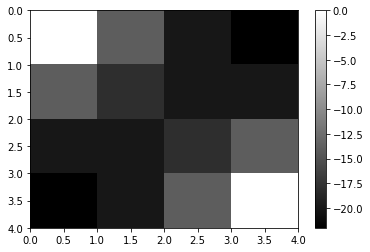

In [222]:
def plot_gridworld_value(V):
    plt.figure()
    c = plt.pcolormesh(V, cmap='gray')
    plt.colorbar(c)
    plt.gca().invert_yaxis()  # In the array, first row = 0 is on top

# Making a plot always helps
plot_gridworld_value(V.reshape(env.shape))

In [223]:
# Test: When you hand in the nodebook we will check that the value function is (approximately) what we expected
# but we need to make sure it is at least of the correct shape
v = policy_eval(random_policy, env)
assert v.shape == (env.nS)

---
## 2. Policy Iteration (2 points)
Using the policy evaluation algorithm we can implement policy iteration to find a good policy for this problem. Note that we do not need to use a discount_factor for episodic tasks but make sure your implementation can handle this correctly!

In [224]:
def policy_improvement(env, discount_factor=1.0):
    """
    Policy Improvement Algorithm. Iteratively evaluates and improves a policy
    until an optimal policy is found.
    
    Args:
        env: The OpenAI envrionment.
        policy_eval_fn: Policy Evaluation function that takes 3 arguments:
            policy, env, discount_factor.
        discount_factor: gamma discount factor.
        
    Returns:
        A tuple (policy, V). 
        policy is the optimal policy, a matrix of shape [S, A] where each state s
        contains a valid probability distribution over actions.
        V is the value function for the optimal policy.
        
    """
    # Start with a random policy
    policy = np.ones([env.nS, env.nA]) / env.nA
    
    stop = False
    while stop == False:
        
        V = policy_eval(policy, env, discount_factor)
        
        # policy improvement
        policy_history = np.copy(policy)
        
        for s in range(env.nS):
            Q = np.zeros(env.nA)
            for action in env.P[s]:
                next_state = env.P[s][action][0][1]
                r = env.P[s][action][0][2]
                probability_env = env.P[s][action][0][0]
                Q[action] = probability_env * (r + discount_factor * V[next_state])
            best_action = np.argmax(Q)
            policy[s, :] = 0
            policy[s, best_action] = 1
         
        # checking stopping criteria
        stop = np.all(policy == policy_history)
    return policy, V

Policy Probability Distribution:
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[[0 3 3 2]
 [0 0 0 2]
 [0 0 1 2]
 [0 1 1 0]]
^<<v
^^^v
^^>v
^>>^

Value Function:
[ 0. -1. -2. -3. -1. -2. -3. -2. -2. -3. -2. -1. -3. -2. -1.  0.]

Reshaped Grid Value Function:
[[ 0. -1. -2. -3.]
 [-1. -2. -3. -2.]
 [-2. -3. -2. -1.]
 [-3. -2. -1.  0.]]



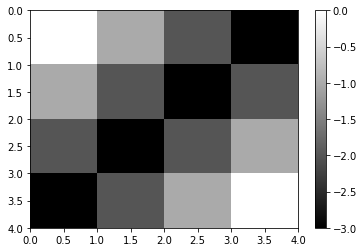

In [225]:
# Let's see what it does
policy, v = policy_improvement(env)
print("Policy Probability Distribution:")
print(policy)
print("")

def print_grid_policy(policy, symbols=["^", ">", "v", "<"]):
    symbols = np.array(symbols)
    for row in policy:
        print("".join(symbols[row]))

print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(np.argmax(policy, axis=1), env.shape))
print_grid_policy(np.reshape(np.argmax(policy, axis=1), env.shape))
print("")

print("Value Function:")
print(v)
print("")

print("Reshaped Grid Value Function:")
print(v.reshape(env.shape))
print("")

plot_gridworld_value(v.reshape(env.shape))

In [226]:
# This is not an empty cell. It is needed for grading.

---
## 3. Value Iteration (3 points)
Now implement the value iteration algorithm.

In [227]:
def value_iteration(env, theta=0.0001, discount_factor=1.0):
    """
    Value Iteration Algorithm.
    
    Args:
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
        
    Returns:
        A tuple (policy, V) of the optimal policy and the optimal value function.        
    """
    

    V = np.zeros(env.nS)
    policy = np.zeros([env.nS, env.nA])
    
    stop = False
    while stop == False:
        delta = 0
        for s in range(env.nS):
            v = V[s]
            Q = np.zeros(env.nA)
            for action in env.P[s]:
                next_state = env.P[s][action][0][1]
                r = env.P[s][action][0][2]
                Q[action] = r + discount_factor * V[next_state]
            V[s] = np.amax(Q)
            delta = max(delta, abs(V[s]-v))
        if delta < theta:
            stop = True
    # change policy
    for s in range(env.nS):
        state_q = np.zeros(env.nA)
        for action in env.P[s]:
            next_state = env.P[s][action][0][1]
            r = env.P[s][action][0][2]
            probability_env = env.P[s][action][0][0]
            state_q[action] = probability_env*(r + discount_factor * V[next_state])
        policy[s, np.argmax(state_q)] = 1
    return policy, V

In [228]:
# Oh let's test again
# Let's see what it does
policy, v = value_iteration(env)
print("Policy Probability Distribution:")
print(policy)
print("")

print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(np.argmax(policy, axis=1), env.shape))
print_grid_policy(np.reshape(np.argmax(policy, axis=1), env.shape))
print("")

print("Value Function:")
print(v)
print("")

print("Reshaped Grid Value Function:")
print(v.reshape(env.shape))
print("")


Policy Probability Distribution:
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[[0 3 3 2]
 [0 0 0 2]
 [0 0 1 2]
 [0 1 1 0]]
^<<v
^^^v
^^>v
^>>^

Value Function:
[ 0. -1. -2. -3. -1. -2. -3. -2. -2. -3. -2. -1. -3. -2. -1.  0.]

Reshaped Grid Value Function:
[[ 0. -1. -2. -3.]
 [-1. -2. -3. -2.]
 [-2. -3. -2. -1.]
 [-3. -2. -1.  0.]]



What is the difference between value iteration and policy iteration? Which algorithm is most efficient (e.g. needs to perform the least *backup* operations)? Please answer *concisely* in the cell below.

In policy iteration, after each policy improvement, policy evaluation is performed until values stay stable and this process is run iteratively until convergence. Although, in value iteration after finding the optimal value function, the optimal policy is calculated only once. The algorithms for policy evaluation and finding optimal value function are highly similar except for a max operation. As a result, value iteration performs fewer operations than the policy iteration.

## 4. Monte Carlo Prediction (7 points)
What is the difference between Dynamic Programming and Monte Carlo? When would you use the one or the other algorithm?

1. DP includes only one-step transition, whereas MC goes all the way to the end of the episode(terminal node).

2. In the MC method the estimates for each state are independent, which means the estimate for one state does not build upon the estimate of any other state, as in the case of DP.

3. DP requires a complete knowledge of the environment (all possible transitions), whereas Monte Carlo methods work on a sampled state-action trajectory on one episode. 

We use DP methods when we have complete knowledge of the environment (all transitions) and enough storage to keep all of it, while MC is used when environment is not fully observable and we only have sampled historical data to train on (data from MDP like sampled episodes).


For the Monte Carlo Prediction we will look at the Blackjack game (Example 5.1 from the book), for which the `BlackjackEnv` is implemented in `blackjack.py`. Note that compared to the gridworld, the state is no longer a single integer, which is why we use a dictionary to represent the value function instead of a numpy array. By using `defaultdict`, each state gets a default value of 0.

In [229]:
from blackjack import BlackjackEnv
env = BlackjackEnv()

For the Monte Carlo algorithm, we need to *interact* with the environment. This means that we start an episode by using `env.reset` and send the environment actions via `env.step` to observe the reward and next observation (state).

In [230]:
# So let's have a look at what we can do in general with an environment...
import gym
?gym.Env

In [231]:
# We can also look at the documentation/implementation of a method
?env.step

In [232]:
??BlackjackEnv

A very simple policy for Blackjack is to *stick* if we have 20 or 21 points and *hit* otherwise. We want to know how good this policy is. This policy is *deterministic* and therefore a function that maps an observation to a single action. Technically, we can implement this as a dictionary or as a function, where we use the latter. To get started, let's implement this simple policy for BlackJack.

In [234]:
def simple_policy(observation):
    """
    A policy that sticks if the player score is >= 20 and hits otherwise.
    """
    # not considering the usable ace
    if observation[0]<20:
        action = 1 # hit
    else:
        action = 0 # stick
    return action

In [235]:
s = env.reset()
print(s)
a = simple_policy(s)
print(env.step(a))

(19, 6, True)
((12, 6, False), 0, False, {})


Now implement either the MC prediction algorithm (either first visit or every visit). Hint: you can use `for i in tqdm(range(num_episodes))` to show a progress bar.

In [236]:
from collections import defaultdict

def mc_prediction(policy, env, num_episodes, discount_factor=1.0):
    """
    Monte Carlo prediction algorithm. Calculates the value function
    for a given policy using sampling.
    
    Args:
        policy: A function that maps an observation to action probabilities.
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
    
    Returns:
        A dictionary that maps from state -> value.
        The state is a tuple and the value is a float.
    """

    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final value function
    V = defaultdict(float)
    
    for _ in tqdm(range(num_episodes)):
        done = False
        state = env.reset()
        state_0 = state
        
        states = []
        while not done:
            action = simple_policy(state)
            [next_state, reward, done, _] = env.step(action)
            states.append((state, reward))
            state = next_state
        G = 0
        for (state, reward) in reversed(states):
            G = G * discount_factor + reward
            returns_sum[state] += G
            returns_count[state] += 1
            V[state] = returns_sum[state] / returns_count[state]
             
    return V

In [237]:
V = mc_prediction(simple_policy, env, num_episodes=1000)
# print(V)

100%|██████████| 1000/1000 [00:00<00:00, 8646.77it/s]


Now make *4 plots* like Figure 5.1 in the book. You can either make 3D plots or heatmaps. Make sure that your results look similar to the results in the book. Give your plots appropriate titles, axis labels, etc.

In [238]:
%%time
# Let's run your code one time
V_10k = mc_prediction(simple_policy, env, num_episodes=10000)
V_500k = mc_prediction(simple_policy, env, num_episodes=500000)

100%|██████████| 500000/500000 [00:50<00:00, 9993.35it/s] 

CPU times: user 50.3 s, sys: 212 ms, total: 50.5 s
Wall time: 51.1 s


In [239]:
V_10k = mc_prediction(simple_policy, env, num_episodes=10000)

100%|██████████| 10000/10000 [00:01<00:00, 9486.48it/s]


(-1, 1)

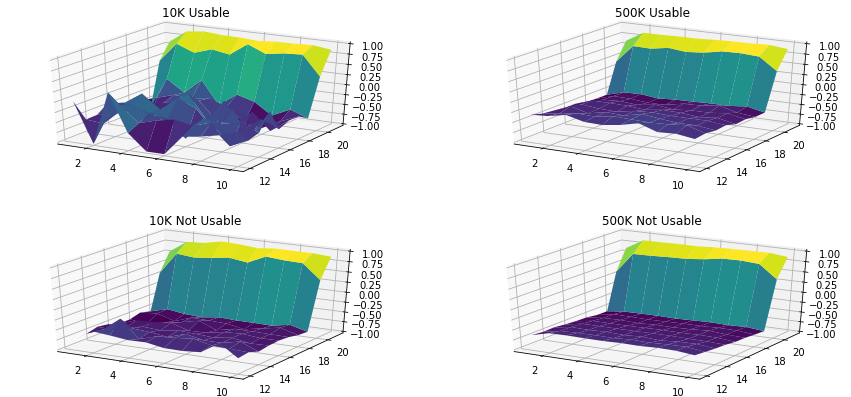

In [240]:
from mpl_toolkits.mplot3d import axes3d, Axes3D
from matplotlib import cm

x = np.linspace(12, 21, 10)
y = np.linspace(1, 10, 10)
X, Y = np.meshgrid(x, y)


fig = plt.figure(figsize=(15, 7))

axs = fig.add_subplot(2, 2, 1, projection='3d')
Z = [V_10k[i, j, True] for i in x for j in y]
Z = np.reshape(Z, (10, 10)).T
axs.plot_surface(Y, X, Z, cmap = cm.viridis)
axs.set_title('10K Usable ')
axs.set_zlim(-1, 1)

axs = fig.add_subplot(2, 2, 2, projection='3d')
Z = [V_500k[i, j, True] for i in x for j in y]
Z = np.reshape(Z, (10, 10)).T
axs.plot_surface(Y, X, Z, cmap = cm.viridis)
axs.set_title('500K Usable ')
axs.set_zlim(-1, 1)

axs = fig.add_subplot(2, 2, 3, projection='3d')
Z = [V_10k[i, j, False] for i in x for j in y]
Z = np.reshape(Z, (10, 10)).T
axs.plot_surface(Y, X, Z, cmap = cm.viridis)
axs.set_title('10K Not Usable ')
axs.set_zlim(-1, 1)

axs = fig.add_subplot(2, 2, 4, projection='3d')
Z = [V_500k[i, j, False] for i in x for j in y]
Z = np.reshape(Z, (10, 10)).T
axs.plot_surface(Y, X, Z, cmap = cm.viridis)
axs.set_title('500K Not Usable ')
axs.set_zlim(-1, 1)


    

## 5. Monte Carlo control with $\epsilon$-greedy policy (5 points)
Now we have a method to evaluate state-values given a policy. Take a moment to think whether we can use the value function to find a better policy? Assuming we do not know the dynamics of the environment, why is this not possible?

We want a policy that selects _actions_ with maximum value, e.g. is _greedy_ with respect to the _action-value_ (or Q-value) function $Q(s,a)$. We need to keep exploring, so with probability $\epsilon$ we will take a random action. First, lets implement a function `make_epsilon_greedy_policy` that takes the Q-value function and returns an $\epsilon$-greedy policy. The policy itself is a function that returns an action.

In [241]:
import random
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        an action according to the epsilon-greedy policy.
    
    """
    def policy_fn(observation):
        rand_switch = random.uniform(0, 1)
        if rand_switch < epsilon:
            action = random.randint(0,nA-1)
        else:
            action = np.argmax(Q[observation])
        return action
    return policy_fn

In [242]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Again, keep track of counts for efficiency
    # returns_sum, returns_count and Q are 
    # nested dictionaries that map state -> (action -> action-value).
    # We could also use tuples (s, a) as keys in a 1d dictionary, but this
    # way Q is in the format that works with make_epsilon_greedy_policy
    
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    returns_count = defaultdict(lambda: np.zeros(env.action_space.n, dtype=int))

    # The final action-value function.
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)

    for _ in tqdm(range(num_episodes)):
        done = False
        state = env.reset()
        episode = []
        while not done:
            action = policy(state)
            [next_state, reward, done, _] = env.step(action)
            episode.append((state, action, reward))
            state = next_state
        G = 0
        for (state, action, reward) in reversed(episode):
            G = G * discount_factor + reward
            returns_sum[state][action] += G
            returns_count[state][action] += 1
            Q[state][action] = returns_sum[state][action] / returns_count[state][action]
    
    return Q, policy

# Test it quickly
Q, policy = mc_control_epsilon_greedy(env, num_episodes=10000, epsilon=0.1)

100%|██████████| 10000/10000 [00:01<00:00, 9086.60it/s]


In [243]:
%%time
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

100%|██████████| 500000/500000 [00:52<00:00, 9435.55it/s]

CPU times: user 52.6 s, sys: 752 ms, total: 53.4 s
Wall time: 53 s


In [244]:
Q_10k, policy_10k = mc_control_epsilon_greedy(env, num_episodes=10000, epsilon=0.1)
Q_50k, policy_50k = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

100%|██████████| 500000/500000 [00:56<00:00, 8921.64it/s]


How can you obtain the (V-)value function from the Q-value function? Plot the (V-)value function that is the result of 500K iterations. Additionally, visualize the greedy policy similar to Figure 5.2 in the book. Use a white square for hitting, black for sticking.

(-1, 1)

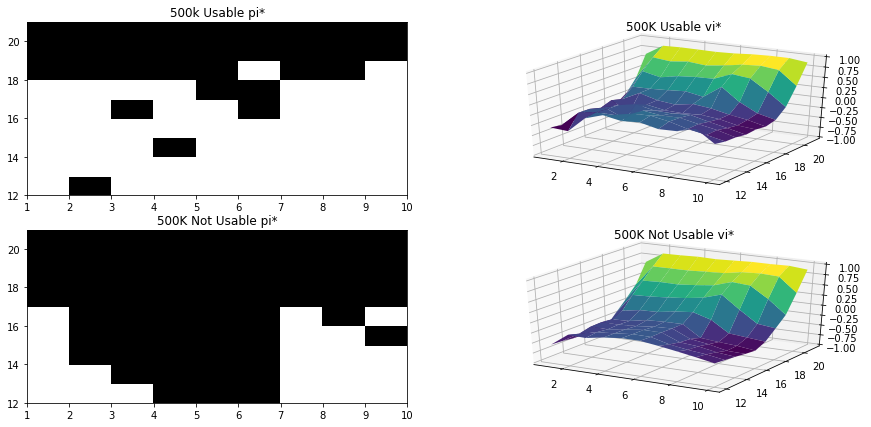

In [245]:

V_50k = {state: max(actions) for (state, actions) in Q_50k.items()}
Policy_50k = {state: ~np.argmax(rewards) for (state, rewards) in Q_50k.items()}

from mpl_toolkits.mplot3d import axes3d, Axes3D
from matplotlib import cm

x = np.linspace(12, 21, 10)
y = np.linspace(1, 10, 10)
X, Y = np.meshgrid(x, y)


fig = plt.figure(figsize=(15, 7))

axs = fig.add_subplot(2, 2, 1)
Z = [Policy_50k[i, j, True] for i in x for j in y]
Z = np.reshape(Z, (10, 10)).T
axs.pcolormesh(Y, X, Z, cmap = 'Greys')
axs.set_title('500k Usable pi*')

axs = fig.add_subplot(2, 2, 2, projection='3d')
Z = [V_50k[i, j, True] for i in x for j in y]
Z = np.reshape(Z, (10, 10)).T
axs.plot_surface(Y, X, Z, cmap = cm.viridis)
axs.set_title('500K Usable vi*')
axs.set_zlim(-1, 1)

axs = fig.add_subplot(2, 2, 3)
Z = [Policy_50k[i, j, False] for i in x for j in y]
Z = np.reshape(Z, (10, 10)).T
axs.pcolormesh(Y, X, Z, cmap = "Greys")
axs.set_title('500K Not Usable pi*')

axs = fig.add_subplot(2, 2, 4, projection='3d')
Z = [V_50k[i, j, False] for i in x for j in y]
Z = np.reshape(Z, (10, 10)).T
axs.plot_surface(Y, X, Z, cmap = cm.viridis)
axs.set_title('500K Not Usable vi*')
axs.set_zlim(-1, 1)

 
